# **Feasibility of a Simple Patient Preference Predictor for Decisional Incapacity** 
### Which Patients Prioritize Involving Their Family Over Receiving Preferred Treatments?
EJ Jardas | NIH Department of Bioethics

<div>
<img src="titleimage.jpg" width="400"/>
</div>

### **Background**

Clinical practice frequently involves incapacitated patients. Up to:
- **40%** of hospitalized adults
- **70%** of older adults who require treatment decisions
- **95%** of critically ill adults

are unable to make their own treatment decisions due to decisional incapacity (Lepping, Stanly, & Turner, 2015).

**Who should make the decisions on behalf of these patients, and how should they make them?**
- Surrogates (patient-designated or next-of-kin) should make these decisons by trying to guess what treatment their loved one would want.
- This is called the *substituted judgment standard*.
- This methodology aims to promote the autonomy of the patient (Buchanan & Brock, 1989; Beauchamp & Childress, 2013).

**In other words, the primary goal of involving a surrogate in treatment decision-making is to represent the preferences and values of the patient, to help them receive wanted and avoid unwanted treatments.**
- Indeed, 95.5% of patients endorse the goal of receiving wanted and avoiding unwanted treatments (Rid et al., 2015).

**However, there is a huge problem with this approach.** 
- Family member surrogates only accurately identify the patient's treatment preferences about one-half of the time when no treatment clearly promotes the patient’s best clinical interests (Shalowitz, Garrett-Mayer, & Wendler, 2006).

**Furthermore, when 1,169 patients were asked which of 8 goals they prioritized most,**
- only 38.5% chose receiving desired and avoiding undesired treatments
- 20.0% chose minmizing the burden on their family
- 14.6% chose involving their family in the decision
- 20.0% could not choose any one priority.

**This is a serious problem because the current process promotes only the first of the above goals, despite the fact that this goal is not prioritized by a majority of patients. (Indeed, there is no overall majority.) This leaves two questions.**
- Can we promote all 3 goals at once, so that the process serves all patients?
- Can we somehow deduce which process a particular patient prefers?


# **Problem Statement: Can we predict which patients prioritize involving their family over receiving preferred treatments?**

## **Method**

### Population
- 1,169 patients were surveyed from the George Washington University Hospital, across a variety 6 inpatient and outpatient units or clinics

### Outcome Variable
If your family does not know which treatments you would want, would you still want your family to help your doctors make treatment decisions for you?
- Yes, help doctors decide
- No, do not help doctors decide

### Features
- 16 variables including demographics, health information, and relevant experiences 

### Model 
- A decision tree classifier, with hyperparameters tuned via gridsearch
- 10 fold stratified cross validation
- Performance evaluated by ROC curve analyses

# **Import, Clean, and Preprocess Data**

### Import Packages

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sklearn

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn import tree

### Import Data
A fake dataset will be pushed to GitHub.

In [39]:
data_path = "datafile.csv"
df = pd.read_csv(data_path) 
df.head()

,relationhip_status,tradeoff,gender,age,race,education,income,current_health,current_qol,reg_doctor,qualityof_familyrelationship,religiosity,experienced_incap_adults,experienced_ACP,have_will,have_dpa
0,Divorced,DontHelpDrsDecide,Female,50.0,Black,HighSchool,<$25K,Fair,Fair,Yes,Good,LittleReligious,ModerateAmt,N,N,Y
1,Married,HelpDrsDecide,Male,52.0,Asian,College,$50-100K,Good,Good,No,Excellent,ModeratelyReligious,ModerateAmt,Y,N,Y
2,Married,HelpDrsDecide,Female,55.0,Black,College,$50-100K,Good,VeryGood,Yes,Excellent,VeryReligious,Lot,Y,N,N
3,Single,NaN,Female,28.0,Black,College,$50-100K,VeryGood,VeryGood,Yes,VeryGood,VeryReligious,Little,N,N,N
4,Divorced,HelpDrsDecide,NaN,NaN,Black,HighSchool,$25-50K,Good,Good,No,Good,ModeratelyReligious,None,N,N,N


Our data look great!

### Explore Data
- How many features and examples are there?
- What are the features?
- How many features are numerical? How many are categorical?

In [40]:
print(df.shape)

(1169, 16)


There are 1,169 examples and 15 features (plus 1 outcome variable).

In [41]:
print(df.dtypes)

relationhip_status               object
tradeoff                         object
gender                           object
age                             float64
race                             object
education                        object
income                           object
current_health                   object
current_qol                      object
reg_doctor                       object
qualityof_familyrelationship     object
religiosity                      object
experienced_incap_adults         object
experienced_ACP                  object
have_will                        object
have_dpa                         object
dtype: object


These are all the features. The outcome variable is called 'tradeoff'.

In [42]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['age']


Age is the only numerical variable.

In [43]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['relationhip_status' 'tradeoff' 'gender' 'race' 'education' 'income'
 'current_health' 'current_qol' 'reg_doctor'
 'qualityof_familyrelationship' 'religiosity' 'experienced_incap_adults'
 'experienced_ACP' 'have_will' 'have_dpa']


The rest of the variables are categorical.

### Missing Data
- What is the proportion of missing observations for each feature and the outcome?
- How will I deal with missing data?

In [44]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col,round(pct_missing*100)))

relationhip_status - 1.0%
tradeoff - 18.0%
gender - 2.0%
age - 2.0%
race - 1.0%
education - 0.0%
income - 10.0%
current_health - 2.0%
current_qol - 2.0%
reg_doctor - 1.0%
qualityof_familyrelationship - 2.0%
religiosity - 3.0%
experienced_incap_adults - 3.0%
experienced_ACP - 1.0%
have_will - 2.0%
have_dpa - 4.0%


Most of the features have less than 5% missing values (except for the outcome variable - tradeoff). The only exception is income, with 10% missing. I'm happy with the size of my dataset, so I've decided to drop all respondents who have any missing values.

In [45]:
df = df.dropna(axis=0)
print(df.shape)

(841, 16)


As you can see, with 841 observations, the dataset is still large enough to be very useful.

### Descriptive Statistics
- For numerical variables, what are the descriptive statistics? Are there any outliers?
- For categorical variables, what are the response options?

In [46]:
class color:
   PRETTY = '\033[36m'
   END = '\033[0m'
    
    # numeric
for each in df_numeric: 
    descript_numeric = df[each].describe()
    print(color.PRETTY + each + '-----' + color.END)
    print(descript_numeric)
    
    # categorical
for each in df_non_numeric:
    descript_non_numeric = df[each].value_counts()
    print(color.PRETTY + each + '-----' + color.END)
    print(descript_non_numeric)    

age-----
count    841.000000
mean      41.570749
std       16.820978
min       18.000000
25%       27.000000
50%       38.000000
75%       53.000000
max       95.000000
Name: age, dtype: float64
relationhip_status-----
Single       437
Married      242
Divorced      75
Partnered     38
Widowed       31
Separated     18
Name: relationhip_status, dtype: int64
tradeoff-----
HelpDrsDecide               565
DontHelpDrsDecide           188
FamilyDecideWhether2Help     88
Name: tradeoff, dtype: int64
gender-----
Female    474
Male      367
Name: gender, dtype: int64
race-----
White       417
Black       318
Hispanic     50
Asian        40
Mixed        13
NatAmer       3
Name: race, dtype: int64
education-----
College                      311
HighSchool                   276
GradSchool                   237
GradeSchool                   15
Didn'tCompleteGradeSchool      2
Name: education, dtype: int64
income-----
$50-100K     214
$100-250K    204
$25-50K      191
<$25K        162
>$250K       

### Create Dummy Variables
For all categorical variables, create dummy variables.

In [47]:
column_names = ['relationhip_status', 'gender', 'race','education','income', 
                'current_health', 'current_qol', 'reg_doctor', 'qualityof_familyrelationship', 
                'religiosity', 'experienced_incap_adults', 'experienced_ACP', 'have_will', 'have_dpa']

df = pd.get_dummies(df, columns = column_names)

print(df.columns.tolist())

['tradeoff', 'age', 'relationhip_status_Divorced', 'relationhip_status_Married', 'relationhip_status_Partnered', 'relationhip_status_Separated', 'relationhip_status_Single', 'relationhip_status_Widowed', 'gender_Female', 'gender_Male', 'race_Asian', 'race_Black', 'race_Hispanic', 'race_Mixed', 'race_NatAmer', 'race_White', 'education_College', "education_Didn'tCompleteGradeSchool", 'education_GradSchool', 'education_GradeSchool', 'education_HighSchool', 'income_$100-250K', 'income_$25-50K', 'income_$50-100K', 'income_<$25K', 'income_>$250K', 'current_health_Excellent', 'current_health_Fair', 'current_health_Good', 'current_health_Poor', 'current_health_VeryGood', 'current_qol_Excellent', 'current_qol_Fair', 'current_qol_Good', 'current_qol_Poor', 'current_qol_VeryGood', 'reg_doctor_No', 'reg_doctor_Yes', "qualityof_familyrelationship_Don'tHaveFamily", 'qualityof_familyrelationship_Excellent', 'qualityof_familyrelationship_Fair', 'qualityof_familyrelationship_Good', 'qualityof_familyrel

In [48]:
print(df.shape)

(841, 58)


Nice! Now you can see that we have 57 features (and the outcome variable) because of adding the dummy variables.

### Prepare the Outcome Variable
You might have noticed that the outcome variable actually has 3 classes: do help, don't help, and let family decide. I'm going to take out the third option because it's not important for the current research question.

In [49]:
# First drop the 3rd class
df = df.drop(df[df['tradeoff']=="FamilyDecideWhether2Help"].index)
print(df.shape)

(753, 58)


Doing so made our dataset smaller, of course, but that's okay!

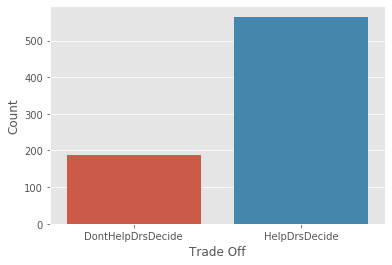

Family should not help Drs decide: 188
Family should help Drs decide: 565
Family should decide for themselves whether to help: 0


In [50]:
sns.countplot(x = 'tradeoff', data=df)
plt.xlabel('Trade Off')
plt.ylabel('Count')
plt.show()
print("Family should not help Drs decide:", len(df[df['tradeoff']=='DontHelpDrsDecide']))
print("Family should help Drs decide:", len(df[df['tradeoff']=='HelpDrsDecide']))
print("Family should decide for themselves whether to help:", len(df[df['tradeoff']=='FamilyDecideWhether2Help']))

In [51]:
565/753

0.750332005312085

As you can see, the classes are pretty imbalanced. I will be using stratified sampling for the train-test split to correct for this.

### Create Labels for Outcome
As you can see below, the outcome variable is currently categorical. I'm going to change it to: 
- 0 = Don't help doctors decide 
- 1 = Help doctors decide

In [52]:
df['tradeoff']

0       DontHelpDrsDecide
1           HelpDrsDecide
2           HelpDrsDecide
5           HelpDrsDecide
6           HelpDrsDecide
              ...        
1152    DontHelpDrsDecide
1153    DontHelpDrsDecide
1154        HelpDrsDecide
1155        HelpDrsDecide
1157        HelpDrsDecide
Name: tradeoff, Length: 753, dtype: object

In [53]:
def define_labels(x):
    if x=='DontHelpDrsDecide':
        return 0
    if x=='HelpDrsDecide':
        return 1

In [54]:
# Note: DON'T RUN THIS MORE THAN ONCE or you will get trouble!
df['tradeoff'] = df['tradeoff'].apply(define_labels)
df['tradeoff']

0       0
1       1
2       1
5       1
6       1
       ..
1152    0
1153    0
1154    1
1155    1
1157    1
Name: tradeoff, Length: 753, dtype: int64

Nice! Looks good.

In [55]:
df.head(3)

,tradeoff,age,relationhip_status_Divorced,relationhip_status_Married,relationhip_status_Partnered,relationhip_status_Separated,relationhip_status_Single,relationhip_status_Widowed,gender_Female,gender_Male,...,experienced_incap_adults_Little,experienced_incap_adults_Lot,experienced_incap_adults_ModerateAmt,experienced_incap_adults_None,experienced_ACP_N,experienced_ACP_Y,have_will_N,have_will_Y,have_dpa_N,have_dpa_Y
0,0,50.0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,0,1
1,1,52.0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,1
2,1,55.0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,1,0,1,0


In [56]:
print(df.shape)

(753, 58)


### Create X and y
Separate the labels from the features.

In [85]:
X = df.drop('tradeoff', axis=1) #create x and y
y = df['tradeoff']
print(X.shape)
print(y.shape)

(753, 57)
(753,)


# **Machine Learning:** The Fun Begins

### Generate 67-33 Train-Test Split, Stratifying over Class

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    shuffle=True,
                                                    random_state=66, 
                                                    stratify=y)

In [59]:
print(len(y_train))
print(len(y_test))
print("Training Set:")
print(y_train.value_counts())
print("Test Set:")
print(y_test.value_counts())

504
249
Training Set:
1    378
0    126
Name: tradeoff, dtype: int64
Test Set:
1    187
0     62
Name: tradeoff, dtype: int64


It stratified over class nicely! Looks great.

### Define Dictionary of Hyperparameters to Be Tuned

In [94]:
to_be_tuned = {'max_depth': range(1,58),
               'min_samples_split': [10, 20, 40, 50, 75, 100]}

### Instantiate Decision Tree Classifier and Grid Search

In [96]:
tree = DecisionTreeClassifier(criterion='entropy')
search = GridSearchCV(estimator = tree,
                     param_grid = to_be_tuned,
                     scoring = 'roc_auc',
                     cv = 10,
                     n_jobs = -1)

### Train the Model

In [98]:
search.fit(X_train, y_train) 

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 58),
                        

### Explore the GridSearch Results

In [99]:
cv_df = pd.DataFrame(search.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008078,0.001849,0.006965,0.001776,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.476721,0.55668,0.449393,0.467611,0.475877,0.438596,0.535088,0.447368,0.429314,0.486486,0.476314,0.039098,337
1,0.007256,0.001734,0.005858,0.002284,1,20,"{'max_depth': 1, 'min_samples_split': 20}",0.476721,0.55668,0.449393,0.467611,0.475877,0.438596,0.535088,0.447368,0.429314,0.486486,0.476314,0.039098,337
2,0.006518,0.001921,0.004484,0.001187,1,40,"{'max_depth': 1, 'min_samples_split': 40}",0.476721,0.55668,0.449393,0.467611,0.475877,0.438596,0.535088,0.447368,0.429314,0.486486,0.476314,0.039098,337
3,0.005783,0.001209,0.005072,0.001203,1,50,"{'max_depth': 1, 'min_samples_split': 50}",0.476721,0.55668,0.449393,0.467611,0.475877,0.438596,0.535088,0.447368,0.429314,0.486486,0.476314,0.039098,337
4,0.006382,0.001526,0.004274,0.001380,1,75,"{'max_depth': 1, 'min_samples_split': 75}",0.476721,0.55668,0.449393,0.467611,0.475877,0.438596,0.535088,0.447368,0.429314,0.486486,0.476314,0.039098,337


### Create Heatmap for GridSearch Hyperparameters

In [104]:
pivoted_df = cv_df.pivot(index="param_min_samples_split",
           columns="param_max_depth",
           values="mean_test_score").round(3)
pivoted_df.style.background_gradient(
    cmap="nipy_spectral",
    axis=None
)

param_max_depth,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
param_min_samples_split,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.476,0.521,0.508,0.511,0.518,0.508,0.522,0.531,0.507,0.509,0.525,0.515,0.525,0.498,0.494,0.484,0.503,0.501,0.497,0.497,0.499,0.491,0.494,0.498,0.501,0.502,0.496,0.493,0.49,0.497,0.513,0.503,0.502,0.495,0.481,0.49,0.496,0.494,0.496,0.51,0.495,0.492,0.494,0.5,0.501,0.495,0.488,0.491,0.508,0.509,0.506,0.481,0.504,0.497,0.496,0.492,0.512
20,0.476,0.521,0.508,0.51,0.516,0.521,0.541,0.537,0.528,0.513,0.534,0.515,0.521,0.531,0.524,0.514,0.511,0.516,0.515,0.515,0.501,0.517,0.515,0.502,0.514,0.524,0.51,0.497,0.513,0.508,0.516,0.52,0.514,0.513,0.506,0.515,0.512,0.516,0.505,0.513,0.513,0.499,0.51,0.512,0.513,0.514,0.507,0.521,0.511,0.51,0.509,0.51,0.503,0.52,0.506,0.524,0.502
40,0.476,0.521,0.504,0.503,0.512,0.531,0.539,0.541,0.525,0.525,0.54,0.54,0.539,0.533,0.535,0.535,0.535,0.533,0.535,0.533,0.535,0.533,0.533,0.533,0.533,0.535,0.535,0.535,0.535,0.536,0.533,0.537,0.534,0.533,0.535,0.533,0.537,0.533,0.535,0.536,0.535,0.537,0.535,0.535,0.533,0.537,0.533,0.535,0.533,0.535,0.533,0.535,0.533,0.533,0.535,0.533,0.537
50,0.476,0.521,0.504,0.505,0.513,0.524,0.532,0.529,0.529,0.526,0.539,0.535,0.531,0.53,0.528,0.528,0.529,0.527,0.528,0.53,0.528,0.527,0.529,0.527,0.527,0.53,0.531,0.531,0.527,0.529,0.53,0.527,0.53,0.528,0.528,0.528,0.53,0.528,0.528,0.528,0.527,0.528,0.527,0.529,0.527,0.53,0.528,0.528,0.53,0.53,0.529,0.53,0.528,0.529,0.527,0.528,0.529
75,0.476,0.521,0.511,0.503,0.512,0.516,0.52,0.518,0.508,0.508,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509,0.509
100,0.476,0.521,0.51,0.504,0.501,0.502,0.512,0.507,0.5,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502,0.502


### Derive the Best-Performing Hyperparameters

In [105]:
best_hypers = search.best_params_
print("And the winners are....:\n", best_hypers)

And the winners are....:
 {'max_depth': 8, 'min_samples_split': 40}


Awesome!

### Extract the Best-Performing Model
And name him America's next top model. :) 

In [106]:
americas_next_top_model = search.best_estimator_
americas_next_top_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Test the Model Accuracy

In [107]:
accuracy_of_test = americas_next_top_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(accuracy_of_test))

Test set accuracy of best model: 0.691


### ROC Curve Analysis
1. Predict the test set probabililties of the positive class.
2. Compute the test ROC AUC.
3. Print it out.

In [108]:
# Step 1
y_pred_proba = americas_next_top_model.predict_proba(X_test)[:,1]

# Step 2
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Step 3
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

Test set ROC AUC score: 0.548


No Skill: ROC AUC=0.500
DecisionTree: ROC AUC=0.548


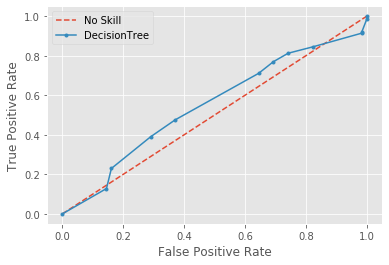

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = americas_next_top_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('DecisionTree: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Confusion Matrix

In [110]:
y_pred = americas_next_top_model.predict(X_test)

confused = confusion_matrix(y_test, y_pred)
# Assigning columns names
confused_cute = pd.DataFrame(confused, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])

# Creating a function to report confusion metrics, note that this code is adopted from source listed in references
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

# Showing the confusion matrix
print(confused_cute)

                 Predicted Negative  Predicted Positive
Actual Negative                   1                  61
Actual Positive                  16                 171


In [111]:
# showing metrics of confusion
stats = confusion_metrics(confused)

--------------------------------------------------
Accuracy: 0.69
Mis-Classification: 0.31
Sensitivity: 0.91
Specificity: 0.02
Precision: 0.02
f_1 Score: 0.03


## What Are the Most Important Features?

In [112]:
antm = americas_next_top_model
importances = antm.feature_importances_
indices = np.argsort(importances)[::-1] # list the features in order from most to least important

In [113]:
features = X.columns
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 0 (0.174847)
2. feature 26 (0.137559)
3. feature 23 (0.092590)
4. feature 30 (0.089582)
5. feature 56 (0.082319)
6. feature 33 (0.072635)
7. feature 8 (0.068955)
8. feature 12 (0.065852)
9. feature 38 (0.057432)
10. feature 2 (0.052023)
11. feature 24 (0.042582)
12. feature 51 (0.041724)
13. feature 22 (0.021900)
14. feature 6 (0.000000)
15. feature 7 (0.000000)
16. feature 21 (0.000000)
17. feature 20 (0.000000)
18. feature 19 (0.000000)
19. feature 18 (0.000000)
20. feature 17 (0.000000)
21. feature 16 (0.000000)
22. feature 1 (0.000000)
23. feature 15 (0.000000)
24. feature 14 (0.000000)
25. feature 13 (0.000000)
26. feature 3 (0.000000)
27. feature 4 (0.000000)
28. feature 11 (0.000000)
29. feature 10 (0.000000)
30. feature 9 (0.000000)
31. feature 5 (0.000000)
32. feature 54 (0.000000)
33. feature 25 (0.000000)
34. feature 50 (0.000000)
35. feature 53 (0.000000)
36. feature 49 (0.000000)
37. feature 48 (0.000000)
38. feature 47 (0.000000)
39. feature 46 (0.000000)
40. f

You can see that 13 of the features add something to the model, and the rest don't seem to. Let's map those onto the actual feature names now, and graph them!

In [116]:
best_indices = indices[:13]
best_indices

array([ 0, 26, 23, 30, 56, 33,  8, 12, 38,  2, 24, 51, 22], dtype=int64)

Text(0.5, 0, 'Relative Importance')

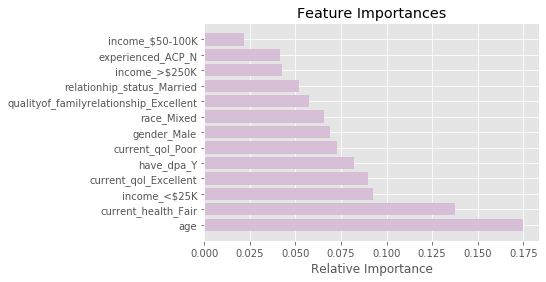

In [117]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(best_indices)), importances[best_indices], color='thistle', align='center')
plt.yticks(range(len(best_indices)), features[best_indices])
plt.xlabel('Relative Importance')

Remember that some of these are dummy variables.
The top three variables are: 
- age
- income less than 25k
- current health = fair

## What Is the Decision Tree Rule?

In [118]:
print(americas_next_top_model.get_n_leaves())
print(americas_next_top_model.get_depth())

18
8


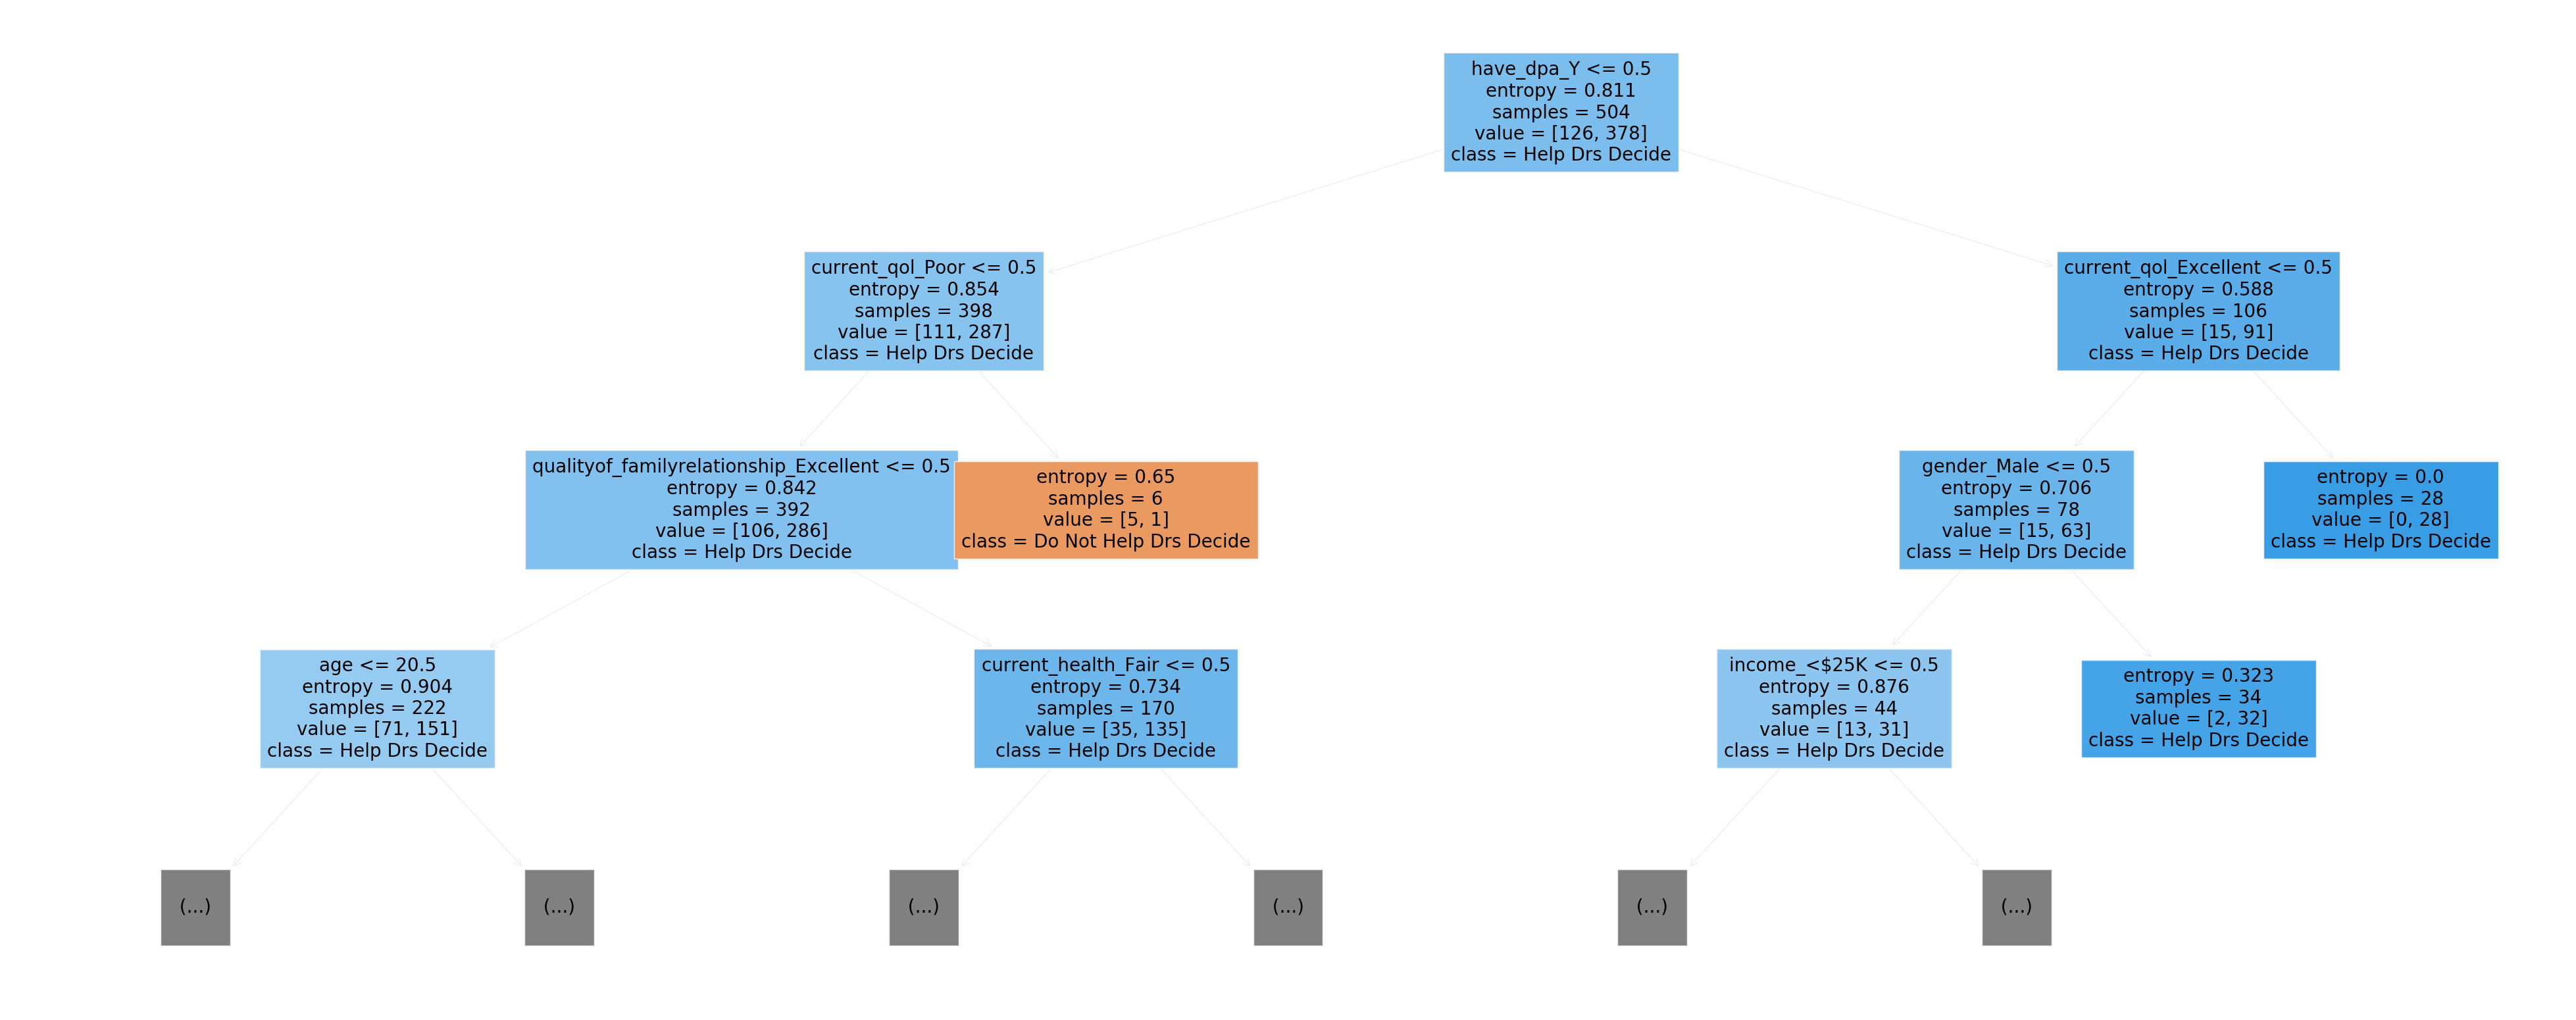

In [120]:
labels = ['Do Not Help Drs Decide', 'Help Drs Decide']
features = list(X)

from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (25,10), dpi=200)
tree.plot_tree(americas_next_top_model, 
               max_depth = 3,
               feature_names = features, 
               class_names= labels,
               filled=True,
               rotate=True,
              fontsize=10);
fig.savefig('decisiontreerule.png')

# **Conclusion**

## Reminder of Background

**Can we somehow figure out which process a particular patient prefers?**
- receiving desired and avoiding undesired treatments, or
- involving their family

*(Given that those goals are often at odds with each other.)*

### Problem Statement: Can we predict which patients prioritize involving their family over receiving preferred treatments?







**The short answer is no.**

- ROC AUC: is a measure of how well a model can separate classes. An AUC of 0.5 means that the model cannot tell between 2 classes at all. Our model's AUC was 0.562. :(
- Sensitivity (True Positive Rate): 88% of people who DO want their family involved in treatment decision-making were predicted to want them involved. 
- Specificity (True Negative Rate): 13% of people who DO NOT want their family involved in treatment decision-making were predicted to NOT want them involved.

### Suggestions?
- My model predicted that **31 patients** (out of the 249 patients in the test set) do NOT want their family involved in treatment decision-making if they do not know their treatment preferences.
- Note that the positive predictive value is 75% and the negative predictive value is 25%. This is roughly the same as the breakdown between classes overall.